# Usage of the SW-NN Model

This notebook demonstrates how to use the SW-NN model to predict LST, compare results with MOD11 and MOD21 products in FPK site, and visualize the results.

## Import Required Libraries

In [14]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import model
import utils


## Set Device

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Model

In [16]:
# Initialize the model
swnn = model.SW_NN(6, 7, 128, 10).to(device)
swnn.load_state_dict(torch.load('model/Sobrino_2000+NN_Emi0.01_WVC10%_BT0.05.pth', map_location=device))
swnn.eval()

SW_NN(
  (relu): ReLU()
  (block1): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_temp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track

## Load Mean and Standard Deviation

In [17]:
mean = np.load('model/mean.npy')
std = np.load('model/std.npy')
mean = torch.tensor(mean, dtype=torch.float32).to(device)
std = torch.tensor(std, dtype=torch.float32).to(device)

## Load Test Data

In [18]:
data = pd.read_csv('data/test_data_at_FPK_site.csv')
data['vza'] = 1/np.cos(data['vza']/180*np.pi)

BT31 = data['BT31'].values
BT32 = data['BT32'].values
# Emisivity
emi_31 = data['emi_31_from_mod11'].values
emi_32 = data['emi_32_from_mod11'].values
# WVC
WVC = data['wvc'].values
# viewing zenith angle
VZA = data['vza'].values

data.head()

,BT31,BT32,wvc,emi_31_from_mod11,emi_32_from_mod11,vza,MOD11 LST,MOD21 LST,LST_insitu
0,247.006408,246.660564,0.262,0.982,0.988,1.084204,248.66,247.76,248.894529
1,246.849195,246.778884,0.186,0.984,0.986,1.039214,247.82,247.28,248.065323
2,242.870922,243.102677,0.273,0.984,0.988,2.330498,243.28,245.86,244.990568
3,242.948477,242.813765,0.213,0.984,0.988,1.404201,244.14,243.66,244.860856
4,248.570760,248.437614,0.218,0.994,0.990,1.751313,248.94,249.04,249.402472


## Extract Features from Test Data

In [19]:
emi_mean = (emi_31 + emi_32) / 2
emi_d = emi_31 - emi_32
features = np.vstack([BT31, BT32, WVC, emi_mean, emi_d, VZA]).T
features = torch.tensor(features).to(device).float()
normalized_features = (features - mean) / std

## Visualize MOD11 LST

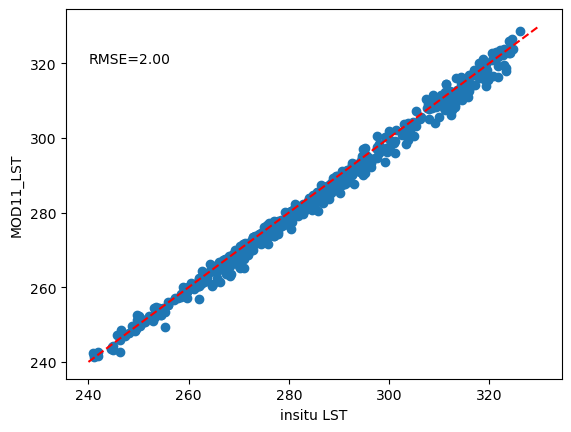

In [20]:
# LST_insitu
LST_insitu = data['LST_insitu'].values
LST_insitu = LST_insitu.reshape(-1, 1)

# MOD11 LST
LST_mod11 = data['MOD11 LST'].values
LST_mod11 = LST_mod11.reshape(-1, 1)
RMSE_mod11 = np.sqrt(np.mean((LST_insitu - LST_mod11) ** 2))

plt.figure()
plt.plot(LST_insitu, LST_mod11, 'o')
plt.plot([240, 330], [240, 330], 'r--')
plt.xlabel('insitu LST')
plt.ylabel('MOD11_LST')
plt.text(240, 320, f'RMSE={RMSE_mod11:.2f}')
plt.show()



## Visualize MOD21 LST

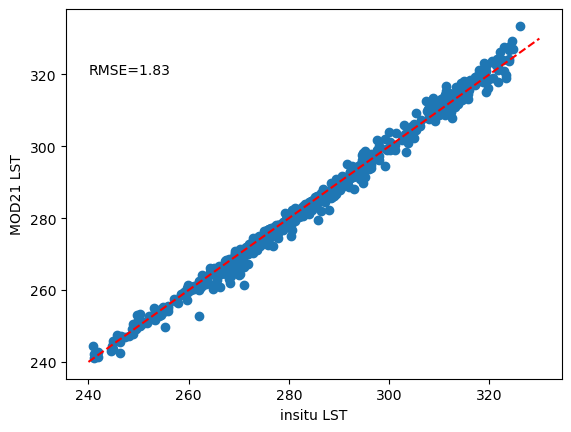

In [21]:
# MOD21 LST
LST_mod21 = data['MOD21 LST'].values
LST_mod21 = LST_mod21.reshape(-1, 1)
RMSE_mod21 = np.sqrt(np.mean((LST_insitu - LST_mod21)**2))

plt.figure()
plt.plot(LST_insitu, LST_mod21, 'o')
plt.plot([240, 330], [240, 330], 'r--')
plt.xlabel('insitu LST')
plt.ylabel('MOD21 LST')
plt.text(240, 320, f'RMSE={RMSE_mod21:.2f}')
plt.show()

## Predict LST Using SW-NN

In [22]:
with torch.no_grad():
    coefficients = swnn(torch.tensor(normalized_features, dtype=torch.float32).to(device)).cpu().numpy()


LST_pred = utils.get_LST(
    np.array([BT31, BT32]).T, WVC, np.array([emi_31, emi_32]).T,
    coefficients
)

C:\Users\Cheng\AppData\Local\Temp\ipykernel_20272\3184335529.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coefficients = swnn(torch.tensor(normalized_features, dtype=torch.float32).to(device)).cpu().numpy()


## Visualize Predicted LST

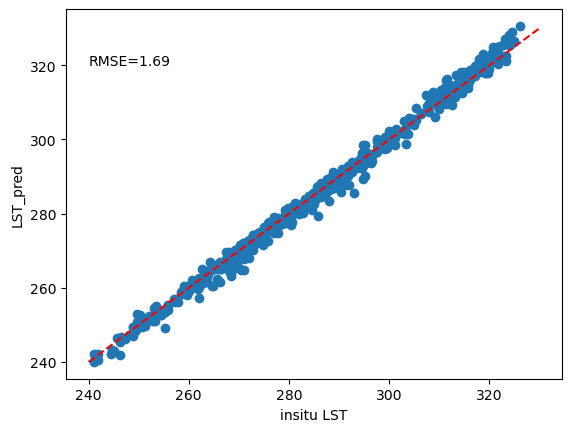

In [23]:
RMSE_swnn = np.sqrt(np.mean((LST_insitu - LST_pred) ** 2))
plt.figure()
plt.plot(LST_insitu, LST_pred, 'o')
plt.plot([240, 330], [240, 330], 'r--')
plt.xlabel('insitu LST')
plt.ylabel('LST_pred')
plt.text(240, 320, f'RMSE={RMSE_swnn:.2f}')
plt.show()